In [2]:
import os
import pickle
import sys
import warnings
from glob import glob
import re
import datetime
import itertools
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
#from mpl_finance import candlestick2_ohlc, volume_overlay
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm
import talib

In [3]:
dataset_dir="../data_dir/"

In [4]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


In [5]:

def make_growth_rate(df,columns_list):
    codes = df["Local Code"].unique()
    seasons = df["Result_FinancialStatement ReportType"].unique()
    columns = df.columns
    columns = columns.to_list()
    for column in columns_list:
        a = "last "+column
        print(a)
        print(type(columns))
        columns.append(a)
    df_result = pd.DataFrame(index=[], columns=columns)
    # columns_list.append("base_date")
    # columns_list.append("Local Code")
    for code,season in tqdm(itertools.product(codes,seasons),total=len(codes)*len(seasons)):
        #df["last "+column] = 0
        #print(columns_list)
        df_test = df[(df["Local Code"]==code) & (df["Result_FinancialStatement ReportType"]==season)].copy()
        for column in columns_list:
            #print(columns)
            df_test["last "+column] = df_test[column]
            df_test["last "+column] = df_test[column].shift()
            #df = pd.merge(df,df_test[["last "+column,"base_date","Local Code"]],on = ["base_date","Local Code"],how="left")
            #df_ab, df_ac, on='a', how='left'
        #print(df_result)
        #print(df_test)
        df_result = pd.concat([df_result,df_test])
        #print(df_test)
    return df_result
stock_fin = dfs["stock_fin"]
stock_fin_dup = stock_fin[~stock_fin.duplicated(subset=['Local Code', 'Result_FinancialStatement ReportType',"Result_FinancialStatement FiscalYear"],keep='last')]
df1 = make_growth_rate(stock_fin_dup,["Result_FinancialStatement NetSales","Result_FinancialStatement OrdinaryIncome","Result_FinancialStatement TotalAssets","Result_FinancialStatement NetAssets"])
df1[df1["Local Code"]== 9984][["last Result_FinancialStatement NetSales","Result_FinancialStatement NetSales","Result_FinancialStatement ReportType","Result_FinancialStatement FiscalYear"]]

  0%|          | 8/18555 [00:00<04:13, 73.17it/s]

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


100%|██████████| 18555/18555 [17:25<00:00,  9.63it/s]


,last Result_FinancialStatement NetSales,Result_FinancialStatement NetSales,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear
2016-04-21,NaN,6810206.0,Q3,2016.0
2017-02-08,6810206.0,6581466.0,Q3,2017.0
2018-02-07,6581466.0,6811274.0,Q3,2018.0
2019-02-06,6811274.0,7168452.0,Q3,2019.0
2020-04-30,7168452.0,7089804.0,Q3,2020.0
2016-11-07,NaN,4271834.0,Q2,2017.0
2017-11-06,4271834.0,4411135.0,Q2,2018.0
2018-11-05,4411135.0,4653853.0,Q2,2019.0
2019-11-06,4653853.0,4651724.0,Q2,2020.0
2020-11-09,4651724.0,2630531.0,Q2,2021.0


In [6]:
df1[df1["Local Code"]== 9984][["last Result_FinancialStatement NetSales","Result_FinancialStatement NetSales",
                               "Result_FinancialStatement OrdinaryIncome", "last Result_FinancialStatement OrdinaryIncome",
                               "Result_FinancialStatement TotalAssets", "last Result_FinancialStatement TotalAssets",
                               "Result_FinancialStatement NetAssets", "last Result_FinancialStatement NetAssets",
                               "Result_FinancialStatement ReportType","Result_FinancialStatement FiscalYear"]]

,last Result_FinancialStatement NetSales,Result_FinancialStatement NetSales,Result_FinancialStatement OrdinaryIncome,last Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement TotalAssets,last Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,last Result_FinancialStatement NetAssets,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear
2016-04-21,NaN,6810206.0,918214.0,NaN,21497648.0,NaN,3855507.0,NaN,Q3,2016.0
2017-02-08,6810206.0,6581466.0,975257.0,918214.0,24867038.0,21497648.0,3981711.0,3855507.0,Q3,2017.0
2018-02-07,6581466.0,6811274.0,563804.0,975257.0,29412718.0,24867038.0,6568877.0,3981711.0,Q3,2018.0
2019-02-06,6811274.0,7168452.0,1809834.0,563804.0,36459477.0,29412718.0,9286389.0,6568877.0,Q3,2019.0
2020-04-30,7168452.0,7089804.0,1345378.0,1809834.0,39406437.0,36459477.0,9191419.0,9286389.0,Q3,2020.0
2016-11-07,NaN,4271834.0,665625.0,NaN,22896077.0,NaN,3126322.0,NaN,Q2,2017.0
2017-11-06,4271834.0,4411135.0,219021.0,665625.0,27973483.0,22896077.0,5468373.0,3126322.0,Q2,2018.0
2018-11-05,4411135.0,4653853.0,1402089.0,219021.0,33807555.0,27973483.0,7343144.0,5468373.0,Q2,2019.0
2019-11-06,4653853.0,4651724.0,1116897.0,1402089.0,36848701.0,33807555.0,8623626.0,7343144.0,Q2,2020.0
2020-11-09,4651724.0,2630531.0,1441472.0,1116897.0,35648197.0,36848701.0,8420605.0,8623626.0,Q2,2021.0


In [8]:
df1["NetSales_growth_rate"] = df1["Result_FinancialStatement NetSales"] / df1["last Result_FinancialStatement NetSales"]

In [10]:
df1[df1["Local Code"]== 9984][["last Result_FinancialStatement NetSales","Result_FinancialStatement NetSales","NetSales_growth_rate",
                               "Result_FinancialStatement ReportType","Result_FinancialStatement FiscalYear"]]

,last Result_FinancialStatement NetSales,Result_FinancialStatement NetSales,NetSales_growth_rate,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear
2016-04-21,NaN,6810206.0,NaN,Q3,2016.0
2017-02-08,6810206.0,6581466.0,0.966412,Q3,2017.0
2018-02-07,6581466.0,6811274.0,1.034917,Q3,2018.0
2019-02-06,6811274.0,7168452.0,1.052439,Q3,2019.0
2020-04-30,7168452.0,7089804.0,0.989029,Q3,2020.0
2016-11-07,NaN,4271834.0,NaN,Q2,2017.0
2017-11-06,4271834.0,4411135.0,1.032609,Q2,2018.0
2018-11-05,4411135.0,4653853.0,1.055024,Q2,2019.0
2019-11-06,4653853.0,4651724.0,0.999543,Q2,2020.0
2020-11-09,4651724.0,2630531.0,0.565496,Q2,2021.0


In [11]:
df1["OrdinaryIncome_growth_rate"] = df1["Result_FinancialStatement OrdinaryIncome"] / df1["last Result_FinancialStatement OrdinaryIncome"]
df1["TotalAssets_growth_rate"] = df1["Result_FinancialStatement TotalAssets"] / df1["last Result_FinancialStatement TotalAssets"]
df1["NetAssets_growth_rate"] = df1["Result_FinancialStatement NetAssets"] / df1["last Result_FinancialStatement NetAssets"]

In [13]:
df1.to_csv(dataset_dir + "stock_fin_growth_rate.csv",index = None)

In [14]:
df1.head()

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare,last Result_FinancialStatement NetSales,last Result_FinancialStatement OrdinaryIncome,last Result_FinancialStatement TotalAssets,last Result_FinancialStatement NetAssets,NetSales_growth_rate,OrdinaryIncome_growth_rate,TotalAssets_growth_rate,NetAssets_growth_rate
2016-01-04,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,45.00,90.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,50.00,100.00,22354.0,2466.0,21251.0,16962.0,1.018207,0.905921,1.053409,1.078587
2018-01-04,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,50.00,100.00,22761.0,2234.0,22386.0,18295.0,1.034884,1.034020,1.077057,1.082482
2019-03-15,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,50.00,100.00,23555.0,2310.0,24111.0,19804.0,1.013415,0.932900,1.041682,1.058776
2020-01-06,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,50.00,100.00,23871.0,2155.0,25116.0,20968.0,1.004482,0.721114,1.019669,1.022987
2016-10-03,2016/10/03,2753,ConsolidatedJP,2016/09,Q2,2017.0,2016/10/03,GB,False,15121.0,...,50.00,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02,2017/10/02,2753,ConsolidatedJP,2017/09,Q2,2018.0,2017/10/02,GB,False,15690.0,...,50.00,100.00,15121.0,1566.0,22268.0,18225.0,1.037630,1.024904,1.077151,1.079616
2018-10-01,2018/10/01,2753,ConsolidatedJP,2018/09,Q2,2019.0,2018/10/01,GB,False,15938.0,...,50.00,100.00,15690.0,1605.0,23986.0,19676.0,1.015806,0.972586,1.054782,1.066020
2019-10-02,2019/10/02,2753,ConsolidatedJP,2019/09,Q2,2020.0,2019/10/02,GB,False,16124.0,...,50.00,100.00,15938.0,1561.0,25300.0,20975.0,1.011670,0.791800,1.025217,1.033993
2020-10-02,2020/10/02,2753,ConsolidatedJP,2020/09,Q2,2021.0,2020/10/02,GB,False,9825.0,...,NaN,NaN,16124.0,1236.0,25938.0,21688.0,0.609340,-1.022654,0.940396,0.928624


In [16]:
stock_list = dfs["stock_list"]
print(len(stock_list))
print(stock_list["Local Code"].nunique())

3711
3711


In [17]:
stock_list.head()

,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0
1,True,20201230,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/05,312430277.0
2,True,20201230,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/02,52656910.0
3,True,20201230,1352,HOHSUI CORPORATION,First Section (Domestic),6050,Wholesale Trade,13,COMMERCIAL & WHOLESALE TRADE,7,TOPIX Small 2,ConsolidatedJP,2020/10/30,8379000.0
4,False,20201230,1375,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedIFRS,2020/11/05,39850000.0


In [35]:
train_X = df1.merge(stock_list, on ="Local Code", how="left")

In [36]:
train_X.head()

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0
1,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0
2,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0
3,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0
4,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,First Section (Domestic),6100,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0


In [83]:
train_X["Net_income_per_stock"] = train_X["Result_FinancialStatement NetIncome"] / train_X["IssuedShareEquityQuote IssuedShare"]
train_X["Ordinary_rate_of_return"] = train_X["Result_FinancialStatement OrdinaryIncome"] / train_X["Result_FinancialStatement NetSales"]


In [84]:
sector_17_mean = sector_17_mean.rename(columns = {"Ordinary_rate_of_return":"17_sector_Ordinary_rate_of_return"})
sector_33_mean = sector_33_mean.rename(columns = {"Ordinary_rate_of_return":"33_sector_Ordinary_rate_of_return"})
#train_X[["Ordinary_rate_of_return","33 Sector(Code)"]]

In [126]:
# train_X["OrdinaryIncome_growth_rate"] = train_X["OrdinaryIncome_growth_rate"].replace([np.inf, -np.inf], np.nan)
# train_X["NetSales_growth_rate"] = train_X["NetSales_growth_rate"].replace([np.inf, -np.inf], np.nan)
# train_X["Net_income_per_stock"] = train_X["Net_income_per_stock"].replace([np.inf, -np.inf], np.nan)
# train_X["Ordinary_rate_of_return"] = train_X["Ordinary_rate_of_return"].replace([np.inf, -np.inf], np.nan)
# train_X["Ordinary_rate_of_return"] = train_X["Ordinary_rate_of_return"].replace([np.inf, -np.inf], np.nan)
# TotalAssets_growth_rate
# NetAssets_growth_rate
train_X =train_X.replace([np.inf, -np.inf], np.nan)

In [111]:
sector_33_mean = train_X[["Ordinary_rate_of_return","33 Sector(Code)"]].groupby('33 Sector(Code)').mean()
sector_17_mean = train_X[["Ordinary_rate_of_return","17 Sector(Code)"]].groupby('17 Sector(Code)').mean()
sector_33_median = train_X[["Ordinary_rate_of_return","33 Sector(Code)"]].groupby('33 Sector(Code)').median()
sector_17_median = train_X[["Ordinary_rate_of_return","17 Sector(Code)"]].groupby('17 Sector(Code)').median()
sector_17_median = sector_17_median.rename(columns = {"Ordinary_rate_of_return":"medianOrdinary_rate_of_return"})
sector_33_median = sector_33_median.rename(columns = {"Ordinary_rate_of_return":"median_Ordinary_rate_of_return"})
sector_17_mean = sector_17_mean.rename(columns = {"Ordinary_rate_of_return":"mean_Ordinary_rate_of_return"})
sector_33_mean = sector_33_mean.rename(columns = {"Ordinary_rate_of_return":"mean_Ordinary_rate_of_return"})

In [131]:
print(sector_33_median)
print(sector_33_mean)

                 median_Ordinary_rate_of_return
33 Sector(Code)                                
50                                     0.026789
1050                                   0.075618
2050                                   0.052140
3050                                   0.042869
3100                                   0.044244
3150                                   0.035982
3200                                   0.074299
3250                                   0.091106
3300                                   0.043225
3350                                   0.076820
3400                                   0.060586
3450                                   0.047813
3500                                   0.045698
3550                                   0.050873
3600                                   0.070079
3650                                   0.050197
3700                                   0.042787
3750                                   0.060784
3800                                   0

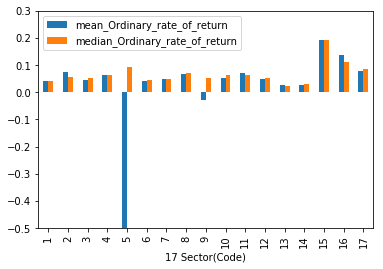

In [119]:
sector_17_info = pd.concat([sector_17_mean,sector_17_median],axis=1)
width=0.01
sector_17_info.plot.bar(ylim=(-0.5, 0.3))

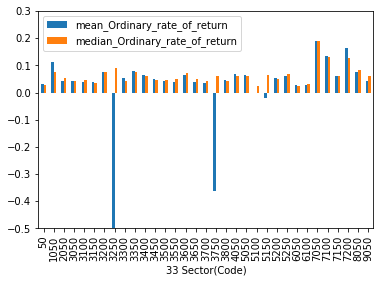

In [120]:
sector_33_info = pd.concat([sector_33_mean,sector_33_median],axis=1)
width=0.01
sector_33_info.plot.bar(ylim=(-0.5, 0.3))

In [78]:
train_X[train_X["17 Sector(Code)"]==16][["17 Sector(name)","Result_FinancialStatement OrdinaryIncome","Result_FinancialStatement NetSales"]].head()

,17 Sector(name),Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetSales
4582,FINANCIALS （EX BANKS）,3004.0,14353.0
4583,FINANCIALS （EX BANKS）,633.0,11553.0
4584,FINANCIALS （EX BANKS）,2678.0,14304.0
4585,FINANCIALS （EX BANKS）,724.0,12090.0
4586,FINANCIALS （EX BANKS）,1226.0,12394.0


In [55]:
train_X["Size (New Index Series)"].unique()

array(['TOPIX Small 2', '-', 'TOPIX Small 1', 'TOPIX Mid400',
       'TOPIX Large70', 'TOPIX Core30'], dtype=object)

In [122]:
train_X.drop(["33_sector_Ordinary_rate_of_return_x","33_sector_Ordinary_rate_of_return_y"],axis=1,inplace=True)


,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,Net_income_per_stock,Ordinary_rate_of_return
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,2.401881e-04,0.110316
1,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,2.181404e-04,0.098150
2,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,2.225207e-04,0.098068
3,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.966768e-04,0.090277
4,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.283437e-04,0.064809
5,2016/10/03,2753,ConsolidatedJP,2016/09,Q2,2017.0,2016/10/03,GB,False,15121.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.578379e-04,0.103565
6,2017/10/02,2753,ConsolidatedJP,2017/09,Q2,2018.0,2017/10/02,GB,False,15690.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.537496e-04,0.102294
7,2018/10/01,2753,ConsolidatedJP,2018/09,Q2,2019.0,2018/10/01,GB,False,15938.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.476171e-04,0.097942
8,2019/10/02,2753,ConsolidatedJP,2019/09,Q2,2020.0,2019/10/02,GB,False,16124.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,1.131585e-04,0.076656
9,2020/10/02,2753,ConsolidatedJP,2020/09,Q2,2021.0,2020/10/02,GB,False,9825.0,...,Retail Trade,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,-1.476171e-04,-0.128651


In [123]:
train_X.columns

Index(['base_date', 'Local Code',
       'Result_FinancialStatement AccountingStandard',
       'Result_FinancialStatement FiscalPeriodEnd',
       'Result_FinancialStatement ReportType',
       'Result_FinancialStatement FiscalYear',
       'Result_FinancialStatement ModifyDate',
       'Result_FinancialStatement CompanyType',
       'Result_FinancialStatement ChangeOfFiscalYearEnd',
       'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome',
       'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome',
       'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets',
       'Result_FinancialStatement CashFlowsFromOperatingActivities',
       'Result_FinancialStatement CashFlowsFromFinancingActivities',
       'Result_FinancialStatement CashFlowsFromInvestingActivities',
       'Forecast_FinancialStatement AccountingStandard',
       'Forecast_FinancialStatement FiscalPeriodEnd',
      

In [127]:
train_X = train_X.merge(sector_17_median,on = "17 Sector(Code)",how = "left")
train_X.head()

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,Net_income_per_stock,Ordinary_rate_of_return,median_Ordinary_rate_of_return
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000240,0.110316,0.030389
1,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000218,0.098150,0.030389
2,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000223,0.098068,0.030389
3,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000197,0.090277,0.030389
4,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,14,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000128,0.064809,0.030389


In [128]:
train_X = train_X.merge(sector_33_median,on = "33 Sector(Code)",how = "left")
train_X.head()

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,Net_income_per_stock,Ordinary_rate_of_return,median_Ordinary_rate_of_return_x,median_Ordinary_rate_of_return_y
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000240,0.110316,0.030389,0.030389
1,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000218,0.098150,0.030389,0.030389
2,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000223,0.098068,0.030389,0.030389
3,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000197,0.090277,0.030389,0.030389
4,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,RETAIL TRADE,7,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000128,0.064809,0.030389,0.030389


In [132]:
train_X = train_X.rename(columns={"median_Ordinary_rate_of_return_x":"sector17_median_ordinary_rate_of_return","median_Ordinary_rate_of_return_y":"sector33_median_ordinary_rate_of_return"})
train_X.tail()

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,Net_income_per_stock,Ordinary_rate_of_return,sector17_median_ordinary_rate_of_return,sector33_median_ordinary_rate_of_return
69621,2020/12/25,4172,NonConsolidated,2020/09,Annual,2020.0,2020/12/25,GB,False,1910.0,...,"IT & SERVICES, OTHERS",-,-,NonConsolidated,2020/12/25,1968000.0,0.000124,0.208377,0.061940,0.069475
69622,2020/12/25,4881,NonConsolidated,2020/09,Q3,2020.0,2020/12/25,GB,False,2.0,...,PHARMACEUTICAL,-,-,NonConsolidated,2020/12/25,14007000.0,-0.000023,-161.500000,0.091106,0.091106
69623,2020/12/25,6230,ConsolidatedJP,2020/09,Q2,2021.0,2020/12/25,GB,False,10359.0,...,MACHINERY,-,-,ConsolidatedJP,2020/12/25,1960000.0,0.000233,0.063327,0.070079,0.070079
69624,2020/12/28,4884,NonConsolidated,2020/09,Annual,2020.0,2020/12/28,GB,False,467.0,...,PHARMACEUTICAL,-,-,NonConsolidated,2020/12/28,3647700.0,-0.000032,-0.248394,0.091106,0.091106
69625,2020/12/29,7360,NonConsolidated,2020/08,Q3,2020.0,2020/12/29,GB,False,379.0,...,"IT & SERVICES, OTHERS",-,-,NonConsolidated,2021/01/14,2481000.0,-0.000008,-0.084433,0.061940,0.061318


In [147]:
stock_price=dfs["stock_price"]
stock_price["base_date"] = stock_price.index

In [150]:
stock_price.head(10)

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,base_date
datetime,,,,,,,,,,,,,,,,,
2016-01-04,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250,2016-01-04
2016-01-05,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990,2016-01-05
2016-01-06,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867,2016-01-06
2016-01-07,1301,2016/01/07,2740.0,2760.0,2710.0,2710.0,2710.0,31400.0,0.1,2760.0,2016/01/06,2760.0,2016/01/06,-50.0,-1.812,2733.471,2016-01-07
2016-01-08,1301,2016/01/08,2700.0,2740.0,2690.0,2700.0,2700.0,26200.0,0.1,2710.0,2016/01/07,2710.0,2016/01/07,-10.0,-0.369,2709.122,2016-01-08
2016-01-12,1301,2016/01/12,2700.0,2730.0,2640.0,2640.0,2640.0,27500.0,0.1,2700.0,2016/01/08,2700.0,2016/01/08,-60.0,-2.222,2671.927,2016-01-12
2016-01-13,1301,2016/01/13,2680.0,2710.0,2670.0,2690.0,2690.0,20400.0,0.1,2640.0,2016/01/12,2640.0,2016/01/12,50.0,1.894,2693.235,2016-01-13
2016-01-14,1301,2016/01/14,2650.0,2650.0,2620.0,2630.0,2630.0,29700.0,0.1,2690.0,2016/01/13,2690.0,2016/01/13,-60.0,-2.230,2633.502,2016-01-14
2016-01-15,1301,2016/01/15,2650.0,2660.0,2630.0,2650.0,2650.0,11400.0,0.1,2630.0,2016/01/14,2630.0,2016/01/14,20.0,0.760,2647.544,2016-01-15


In [170]:
train_X = pd.merge(train_X,stock_price[["EndOfDayQuote Close","EndOfDayQuote Date","Local Code"]],left_on=["base_date","Local Code"],right_on=["EndOfDayQuote Date","Local Code"],how="left")
train_X.head(10)

,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,...,Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare,Net_income_per_stock,Ordinary_rate_of_return,sector17_median_ordinary_rate_of_return,sector33_median_ordinary_rate_of_return,EndOfDayQuote Close,EndOfDayQuote Date
0,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000240,0.110316,0.030389,0.030389,4710.0,2016/01/04
1,2017/01/04,2753,ConsolidatedJP,2016/12,Q3,2017.0,2017/01/04,GB,False,22761.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000218,0.098150,0.030389,0.030389,3980.0,2017/01/04
2,2018/01/04,2753,ConsolidatedJP,2017/12,Q3,2018.0,2018/01/04,GB,False,23555.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000223,0.098068,0.030389,0.030389,5300.0,2018/01/04
3,2019/03/15,2753,ConsolidatedJP,2018/12,Q3,2019.0,2019/01/07,GB,False,23871.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000197,0.090277,0.030389,0.030389,3655.0,2019/03/15
4,2020/01/06,2753,ConsolidatedJP,2019/12,Q3,2020.0,2020/01/06,GB,False,23978.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000128,0.064809,0.030389,0.030389,3685.0,2020/01/06
5,2016/10/03,2753,ConsolidatedJP,2016/09,Q2,2017.0,2016/10/03,GB,False,15121.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000158,0.103565,0.030389,0.030389,3685.0,2016/10/03
6,2017/10/02,2753,ConsolidatedJP,2017/09,Q2,2018.0,2017/10/02,GB,False,15690.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000154,0.102294,0.030389,0.030389,4710.0,2017/10/02
7,2018/10/01,2753,ConsolidatedJP,2018/09,Q2,2019.0,2018/10/01,GB,False,15938.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000148,0.097942,0.030389,0.030389,4580.0,2018/10/01
8,2019/10/02,2753,ConsolidatedJP,2019/09,Q2,2020.0,2019/10/02,GB,False,16124.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,0.000113,0.076656,0.030389,0.030389,3445.0,2019/10/02
9,2020/10/02,2753,ConsolidatedJP,2020/09,Q2,2021.0,2020/10/02,GB,False,9825.0,...,TOPIX Small 2,ConsolidatedJP,2021/01/04,6848800.0,-0.000148,-0.128651,0.030389,0.030389,2895.0,2020/10/02


In [172]:
stock_price[(stock_price["EndOfDayQuote Date"] == "2016/01/04") &(stock_price["Local Code"] == 2753)]

,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP,base_date
datetime,,,,,,,,,,,,,,,,,
2016-01-04,2753,2016/01/04,4750.0,4800.0,4620.0,4710.0,4710.0,12200.0,1.0,4680.0,2015/12/30,4680.0,2015/12/30,30.0,0.641,4706.598,2016-01-04


In [176]:
train_X["sector17's_Ordinary_rate_of_return_diff"] = train_X["Ordinary_rate_of_return"] - train_X["sector17_median_ordinary_rate_of_return"]
train_X["sector33's_Ordinary_rate_of_return_diff"] = train_X["Ordinary_rate_of_return"] - train_X["sector33_median_ordinary_rate_of_return"]

In [177]:
train_X["PBR"] =train_X["EndOfDayQuote Close"] * train_X["IssuedShareEquityQuote IssuedShare"] / train_X["Result_FinancialStatement NetAssets"]


In [179]:
train_X["stability"] = train_X["Result_FinancialStatement NetAssets"] / train_X["Result_FinancialStatement TotalAssets"]
train_X["ROE"] = train_X["Result_FinancialStatement NetIncome"] / train_X["Result_FinancialStatement NetAssets"]
train_X["ROA"] = train_X["Result_FinancialStatement NetIncome"] / train_X["Result_FinancialStatement TotalAssets"]

In [181]:
# df.loc[df['B'] % 2 == 0, 'D'] = 'even'
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromOperatingActivities'] <= 0, 'Operating_cash_flow'] = 0
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromOperatingActivities'] > 0, 'Operating_cash_flow'] = 4
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromFinancingActivities'] <= 0, 'Financial_cash_flow'] = 0
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromFinancingActivities'] > 0, 'Financial_cash_flow'] = 1
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromInvestingActivities'] <= 0, 'Investing_cash_flow'] = 0
train_X.loc[train_X['Result_FinancialStatement CashFlowsFromInvestingActivities'] > 0, 'Investing_cash_flow'] = 2

In [183]:
train_X["cash_evaluation"] = train_X["Operating_cash_flow"] + train_X["Financial_cash_flow"] + train_X["Investing_cash_flow"]

In [184]:
train_X.to_csv(dataset_dir + "train_X.csv",index=None)